<b>Python Version<b>

In [1]:
!python -V

Python 3.8.5


<b>Libraries<b>

In [2]:
import pkg_resources
import subprocess
import sys
import os

REQUIRED = {
  'numpy', 'pandas', 'seaborn', 'matplotlib', 'sklearn'
}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = REQUIRED - installed
if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 

## EDA and Pre-processing

### Exploring the dataset

In [3]:
task_data = pd.read_csv("analytics_task_data.csv")
print(task_data.head())

print(task_data.describe())
print("\nNo.of missing values:\n",task_data.isnull().sum())

           x           y
0  13.357717  547.521179
1  10.338816  130.596711
2   7.721289   41.221844
3   8.726541   77.597025
4   7.525586   31.740437
                x           y
count  488.000000  462.000000
mean    10.649274  251.418730
std      2.209457  233.150756
min      7.001618    3.751412
25%      8.788517   69.000816
50%     10.539698  152.701811
75%     12.670049  391.265698
max     14.482900  888.310387

No.of missing values:
 x    12
y    38
dtype: int64


### Data Plots

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>]], dtype=object)

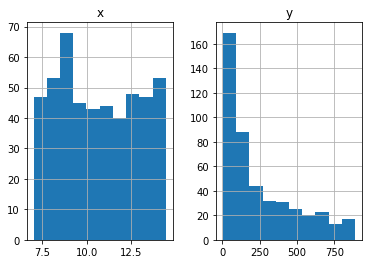

In [4]:
task_data.hist()  # distribution is not normal
# task_data.plot()
# task_data.plot(y='y',x='x')

<AxesSubplot:xlabel='y'>

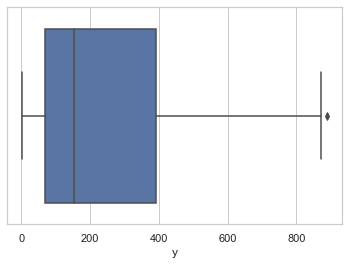

In [5]:
sns.set_theme(style="whitegrid") # outlier check
# sns.boxplot(x=task_data["x"])
sns.boxplot(x=task_data["y"])

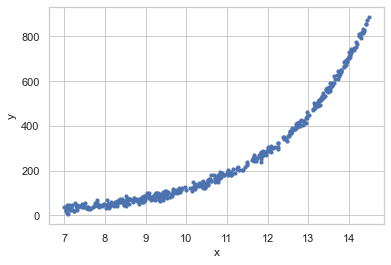

In [6]:
# scatter plot
plt.scatter(task_data["x"],task_data["y"],s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()      # polynomial regresion as second model

<b>Missing value Imputaion using KNN<b>

In [7]:
# Missing value treatment
# task_data_final = task_data.fillna(task_data.median()) # gave decent model result

# knn missing imputation - gave much better model result
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors= 5)
task_data_final = imputer.fit_transform(task_data)
task_data_final = pd.DataFrame(task_data_final, columns = ['x','y'])

# 

## Regression Models

In [8]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [9]:
X = pd.DataFrame(task_data_final["x"])
y = pd.DataFrame(task_data_final["y"])

# Test (70%) and train (30%) split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Model 1 - Linear Regression

In [10]:
model_lr = LinearRegression()  
model_lr.fit(X_train, y_train) #training the algorithm
# prediction on test data
y_pred_lr = model_lr.predict(X_test)

In [11]:
print("R^2 value:",round(r2_score(y_test,y_pred_lr),2))
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_lr))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_lr))  
print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)),2))

R^2 value: 0.86
Root Mean Squared Error (RMSE): 90.23


<b>K-Fold cross-validation<b>

In [12]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(model_lr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=folds)
scores = scores*-1
print("RMSE scores for 5 splits: ",np.round(scores,2))
print("Avg. RMSE for model with cross validation: ",np.round(scores.mean()))

RMSE scores for 5 splits:  [88.46 82.37 82.9  91.05 87.71]
Avg. RMSE for model with cross validation:  87.0


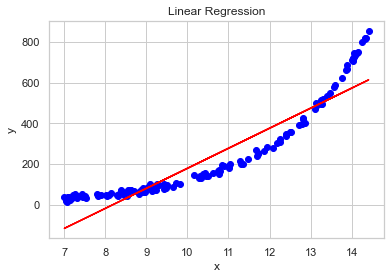

In [13]:
# Visualising the Linear Regression results
plt.scatter(X_test, y_test, color = 'blue')
plt.plot(X_test, y_pred_lr, color = 'red')
plt.title('Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.show()                               # NOT THE BEST MODEL

### Model 2 - Polynomial Regression 

In [14]:
from sklearn.preprocessing import PolynomialFeatures

# transform our data into a polynomial
poly = PolynomialFeatures(degree = 2)
X_train_poly, X_test_poly = poly.fit_transform(X_train), poly.fit_transform(X_test)

model_lr_poly = LinearRegression()
model_lr_poly = model_lr_poly.fit(X_train_poly, y_train) #training the algorithm
coefficient = model_lr_poly.coef_
intercept = model_lr_poly.intercept_
# prediction on test data
y_pred_poly = model_lr_poly.predict(X_test_poly)

In [15]:
# print("R^2 value:",round(r2_score(y_test,y_pred_poly),2))
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_poly))  
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_poly))  
print('Root Mean Squared Error (RMSE):', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_poly)),2))

Root Mean Squared Error (RMSE): 27.14


<b>K-Fold cross-validation<b>

In [16]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(model_lr_poly, X_train_poly, y_train, scoring='neg_root_mean_squared_error', cv=folds)
scores = scores*-1
print("RMSE scores for 5 splits: ",np.round(scores,2))
print("Avg. RMSE for model with cross validation: ",np.round(scores.mean()))

RMSE scores for 5 splits:  [25.86 22.78 30.31 28.5  25.76]
Avg. RMSE for model with cross validation:  27.0


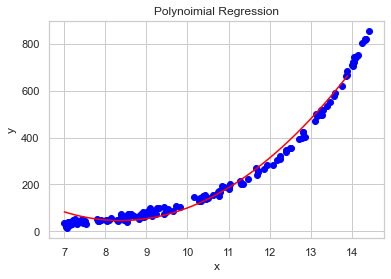

In [17]:
# Visualising the Linear Regression results
x_axis = np.arange(7,14,0.1)
# predicting using polynomial function
response = intercept + coefficient[0,1] * x_axis + coefficient[0,2] * x_axis**2
def polynomial_prediction_plot():
    plt.scatter(X_test, y_test, color = 'blue')
    plt.plot(x_axis, response, color = 'red')
    plt.title('Polynoimial Regression')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show() 
polynomial_prediction_plot()                            # THE BEST MODEL

# 

# Final Notes

-- Plotted data and used KNN approach to treat missing value.

-- Performed <b>Linear Regression</b> and <b>Polynomial Regression</b>. 
   
-- Choosen matric for evaluation is <b>RMSE (Root Mean Square Error)</b>, performed the evaluation using cross-validation

-- Average RMSE for Linear Regression model with cross validation:  <b>87.0</b>

<b>Polynomial Regression</b> model came out to be the best with an average RMSE score of <b>27.0</b>   

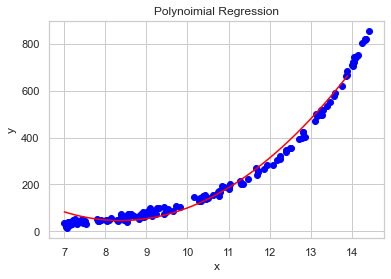

In [18]:
# Plotting the predictions from the best model against the data
polynomial_prediction_plot()  